In [2]:
!pip install fredapi yfinance pandas matplotlib --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


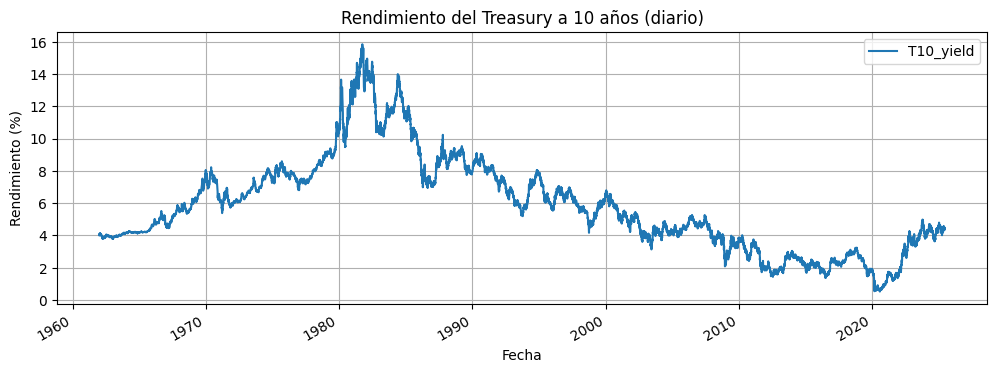

In [3]:
# ---------------------------------------------------------
# DESCARGA Y VISUALIZACIÓN DE LA TASA DEL TREASURY A 10 AÑOS (T10)
# ---------------------------------------------------------

from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# Inicialización del cliente FRED con clave API personal
fred = Fred(api_key='9b74884541c442ef0b56869ce3105d01')

# Descarga de la serie diaria correspondiente al rendimiento del bono del Tesoro de EE.UU. a 10 años (DGS10)
t10 = fred.get_series('DGS10')
t10 = t10.dropna().to_frame(name='T10_yield')
t10.index.name = 'date'

# Visualización de la evolución histórica del rendimiento del T10
t10.plot(figsize=(12, 4), title='Rendimiento del Treasury a 10 años (diario)')
plt.ylabel('Rendimiento (%)')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

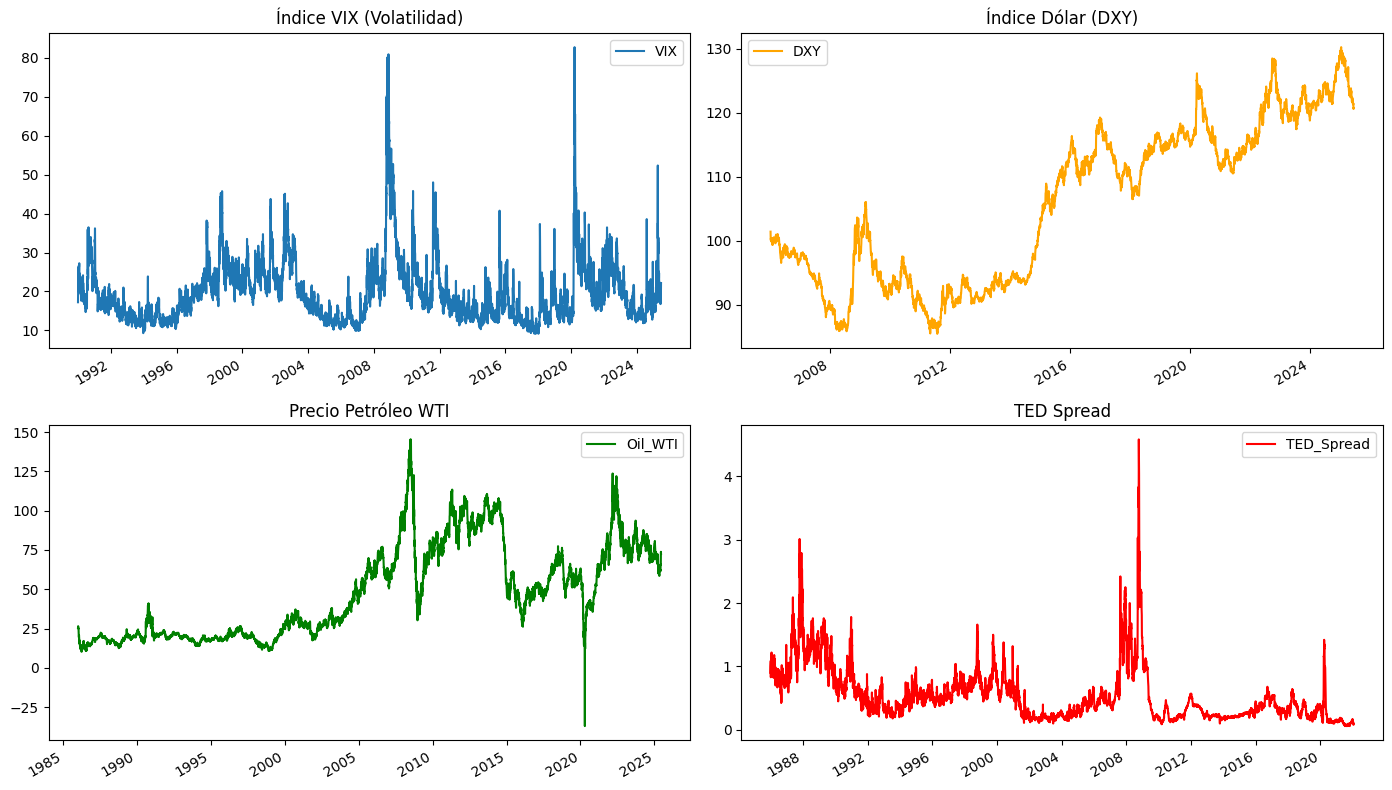

In [4]:
# ---------------------------------------------------------
# DESCARGA DE VARIABLES MACROFINANCIERAS DIARIAS
# ---------------------------------------------------------

# Descarga de variables desde FRED
vix = fred.get_series('VIXCLS').dropna().to_frame(name='VIX')
dxy = fred.get_series('DTWEXBGS').dropna().to_frame(name='DXY')
oil = fred.get_series('DCOILWTICO').dropna().to_frame(name='Oil_WTI')
ted = fred.get_series('TEDRATE').dropna().to_frame(name='TED_Spread')

# Visualización conjunta de las variables descargadas
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
vix.plot(ax=ax[0,0], title='Índice VIX (Volatilidad)')
dxy.plot(ax=ax[0,1], title='Índice Dólar (DXY)', color='orange')
oil.plot(ax=ax[1,0], title='Precio Petróleo WTI', color='green')
ted.plot(ax=ax[1,1], title='TED Spread', color='red')
plt.tight_layout()
plt.show()

/tmp/ipykernel_42335/3820780243.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_raw = yf.download('^GSPC', start='1990-01-01', progress=False)


Columnas disponibles en el DataFrame de S&P 500:
MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


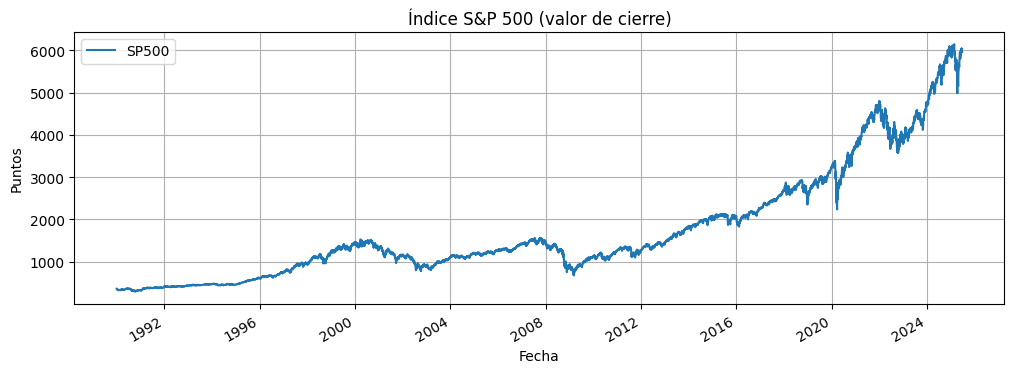

In [5]:
# ---------------------------------------------------------
# DESCARGA DEL ÍNDICE S&P 500 DESDE YAHOO FINANCE (MULTIINDEX CORREGIDO)
# ---------------------------------------------------------

import yfinance as yf

# Descarga del índice S&P 500 desde Yahoo Finance
# Alineado al resto de las variables macro utilizadas en el análisis
sp500_raw = yf.download('^GSPC', start='1990-01-01', progress=False)

# Confirmación de columnas disponibles bajo formato MultiIndex
print("Columnas disponibles en el DataFrame de S&P 500:")
print(sp500_raw.columns)

# Selección de la columna 'Close' del índice '^GSPC' utilizando acceso por tupla
sp500 = sp500_raw[('Close', '^GSPC')].dropna()
sp500.name = 'SP500'
sp500 = sp500.to_frame()

# Visualización de la evolución histórica del índice
sp500.plot(figsize=(12, 4), title='Índice S&P 500 (valor de cierre)')
plt.ylabel('Puntos')
plt.xlabel('Fecha')
plt.grid(True)
plt.show()

In [6]:
# ---------------------------------------------------------
# UNIFICACIÓN DE VARIABLES Y EXPORTACIÓN DE LA SABANA FINAL
# ---------------------------------------------------------

# Lista de todas las series previamente procesadas y alineadas
series = [t10, vix, dxy, oil, ted, sp500]

# Fusión iterativa de las series usando un join tipo "inner" por índice temporal (fecha)
# Se conservan solo aquellas fechas en las que todas las variables están disponibles
df_final = series[0]
for df in series[1:]:
    df_final = df_final.join(df, how='inner')

# Verificación rápida de la estructura del DataFrame final
print("\nVista preliminar del DataFrame unificado:")
display(df_final.head())

# Información general de la muestra disponible
print(f"Número total de observaciones: {df_final.shape[0]}")
print(f"Rango de fechas: {df_final.index.min().date()} → {df_final.index.max().date()}")

# Revisión de datos faltantes (debería ser 0 si el join fue exitoso)
print("\nConteo de valores nulos por variable:")
print(df_final.isnull().sum())

# Exportación de la sabana a un archivo CSV para uso posterior
df_final.to_csv("sabana_macro_t10.csv", index=True)

print("\n✅ Sabana exportada exitosamente como 'sabana_macro_t10.csv'")


Vista preliminar del DataFrame unificado:


,T10_yield,VIX,DXY,Oil_WTI,TED_Spread,SP500
2006-01-03,4.37,11.14,100.7558,63.11,0.47,1268.800049
2006-01-04,4.36,11.37,100.2288,63.41,0.45,1273.459961
2006-01-05,4.36,11.31,100.2992,62.81,0.45,1273.479980
2006-01-06,4.38,11.00,100.0241,64.21,0.43,1285.449951
2006-01-09,4.38,11.13,100.1794,63.56,0.42,1290.150024


Número total de observaciones: 3903
Rango de fechas: 2006-01-03 → 2022-01-21

Conteo de valores nulos por variable:
T10_yield     0
VIX           0
DXY           0
Oil_WTI       0
TED_Spread    0
SP500         0
dtype: int64

✅ Sabana exportada exitosamente como 'sabana_macro_t10.csv'


In [7]:
# ---------------------------------------------------------
# CORRECCIÓN Y LIMPIEZA INICIAL DE LA SABANA DE DATOS
# ---------------------------------------------------------

# Al cargar el CSV original, la columna de fechas quedó registrada como 'Unnamed: 0' de tipo object.
# Este paso renombra correctamente la columna como 'date', la convierte a tipo datetime,
# y la establece como índice del DataFrame, permitiendo su uso adecuado en análisis de series temporales.

df = pd.read_csv("sabana_macro_t10.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "date"}).set_index("date")

# Verificación rápida del índice y estructura
print("Índice temporal:", df.index.name)
print(df.dtypes)

Índice temporal: date
T10_yield     float64
VIX           float64
DXY           float64
Oil_WTI       float64
TED_Spread    float64
SP500         float64
dtype: object


📊 Resumen estadístico:


,T10_yield,VIX,DXY,Oil_WTI,TED_Spread,SP500
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,2.668916,19.514607,102.175941,70.793451,0.426177,2010.500540
std,1.085702,9.362126,10.538497,22.614747,0.444328,904.633256
min,0.520000,9.140000,85.469200,-36.980000,0.060000,676.530029
25%,1.880000,13.400000,92.842250,52.705000,0.200000,1313.679993
50%,2.490000,16.870000,98.912500,68.290000,0.290000,1805.810059
75%,3.380000,22.510000,112.795850,89.590000,0.440000,2596.859985
max,5.260000,82.690000,126.134200,145.310000,4.580000,4793.540039



🧾 Tipos de datos:
T10_yield     float64
VIX           float64
DXY           float64
Oil_WTI       float64
TED_Spread    float64
SP500         float64
dtype: object


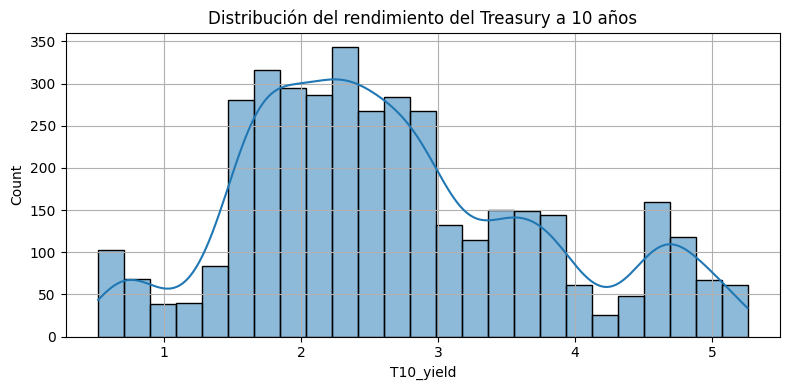

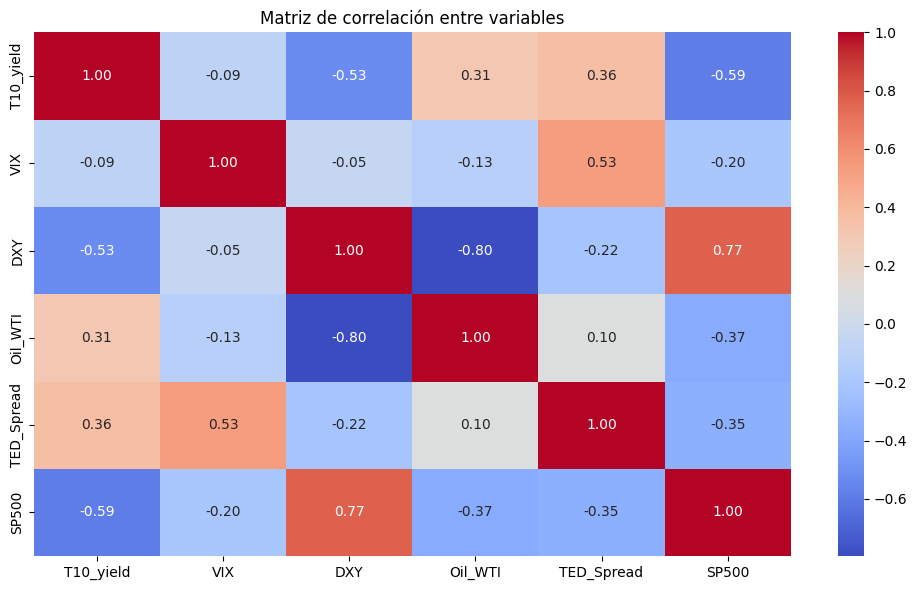

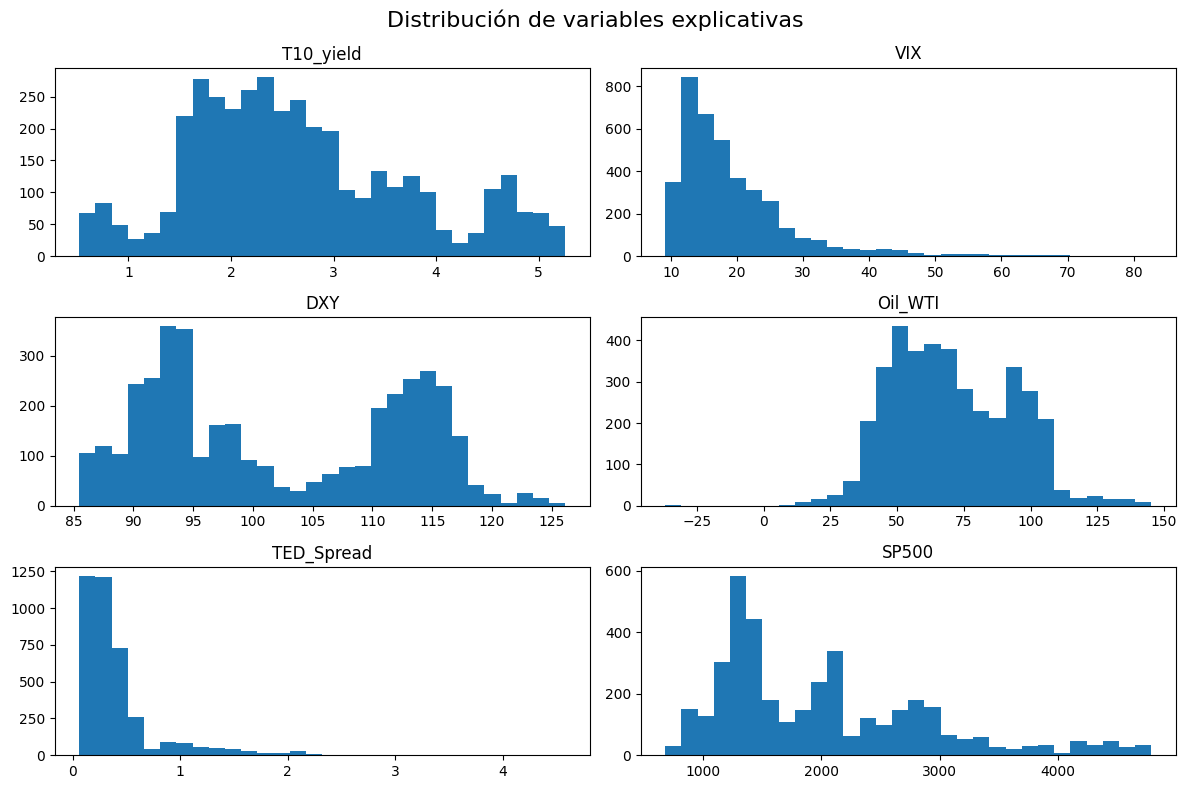

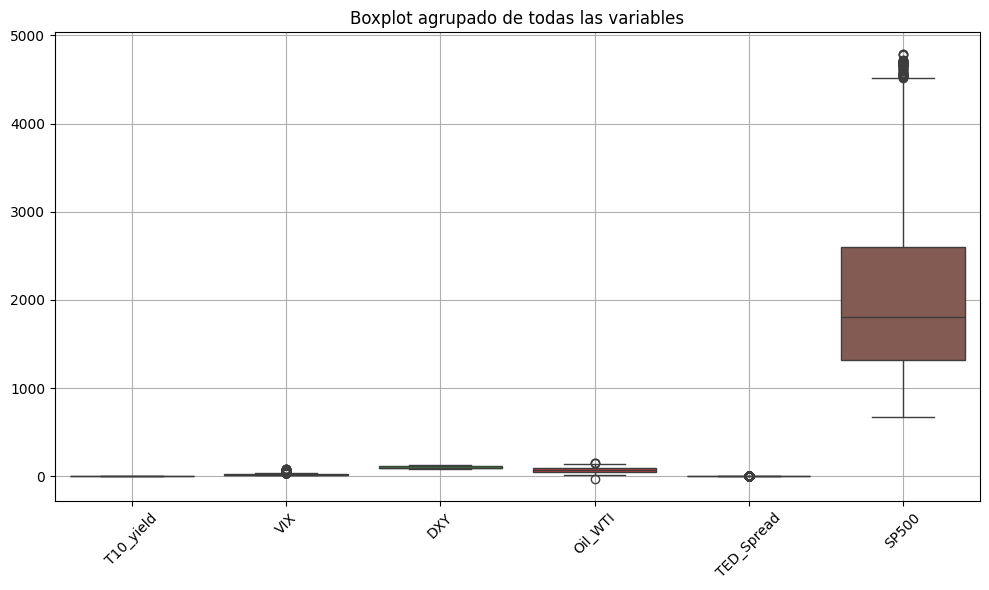

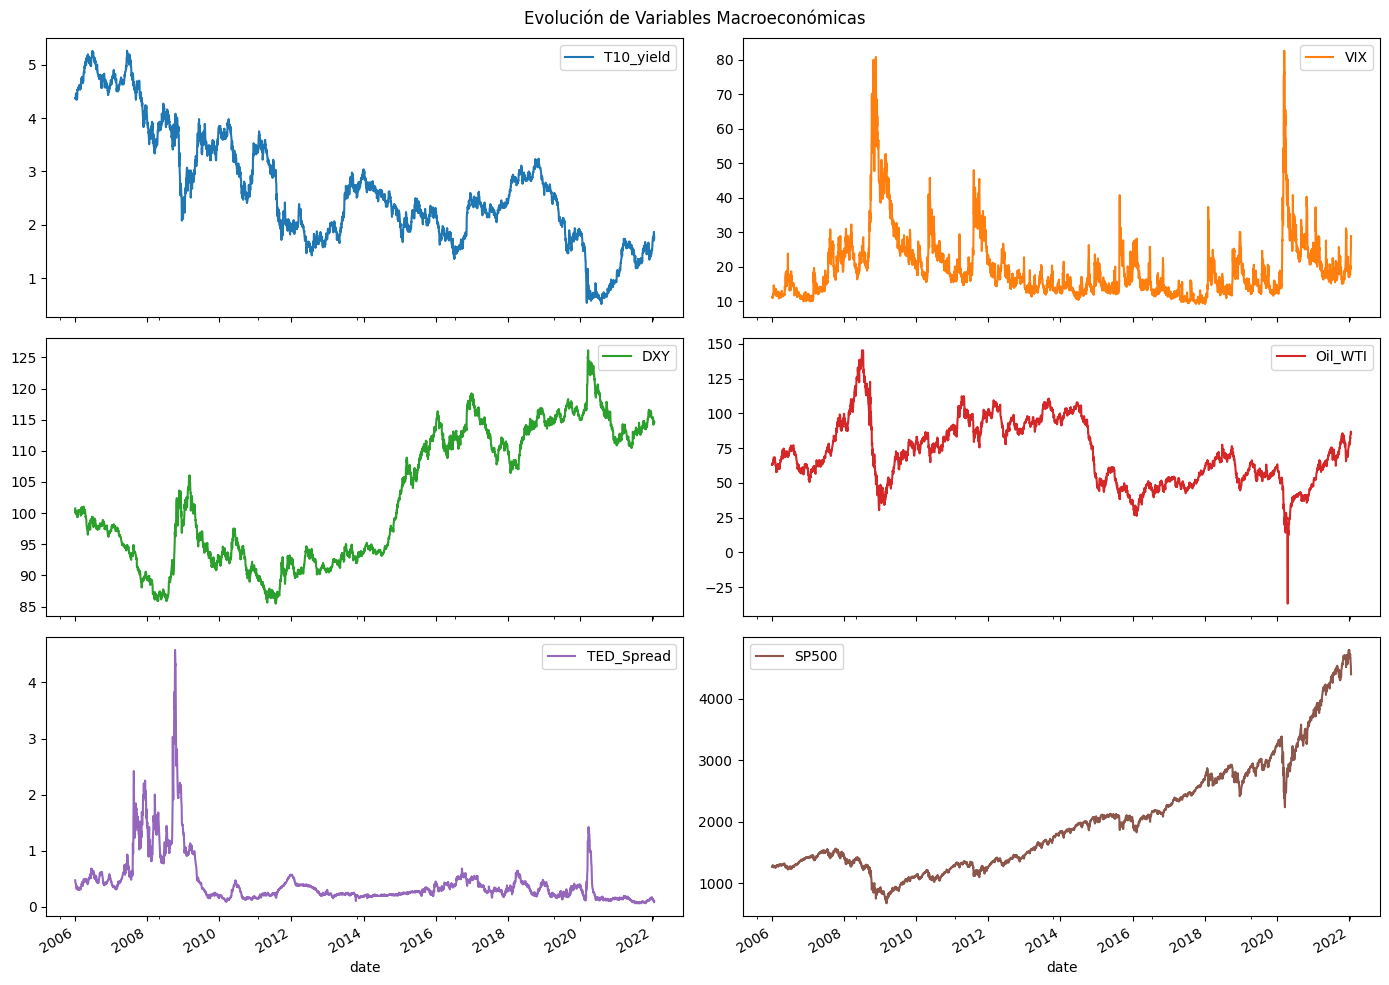

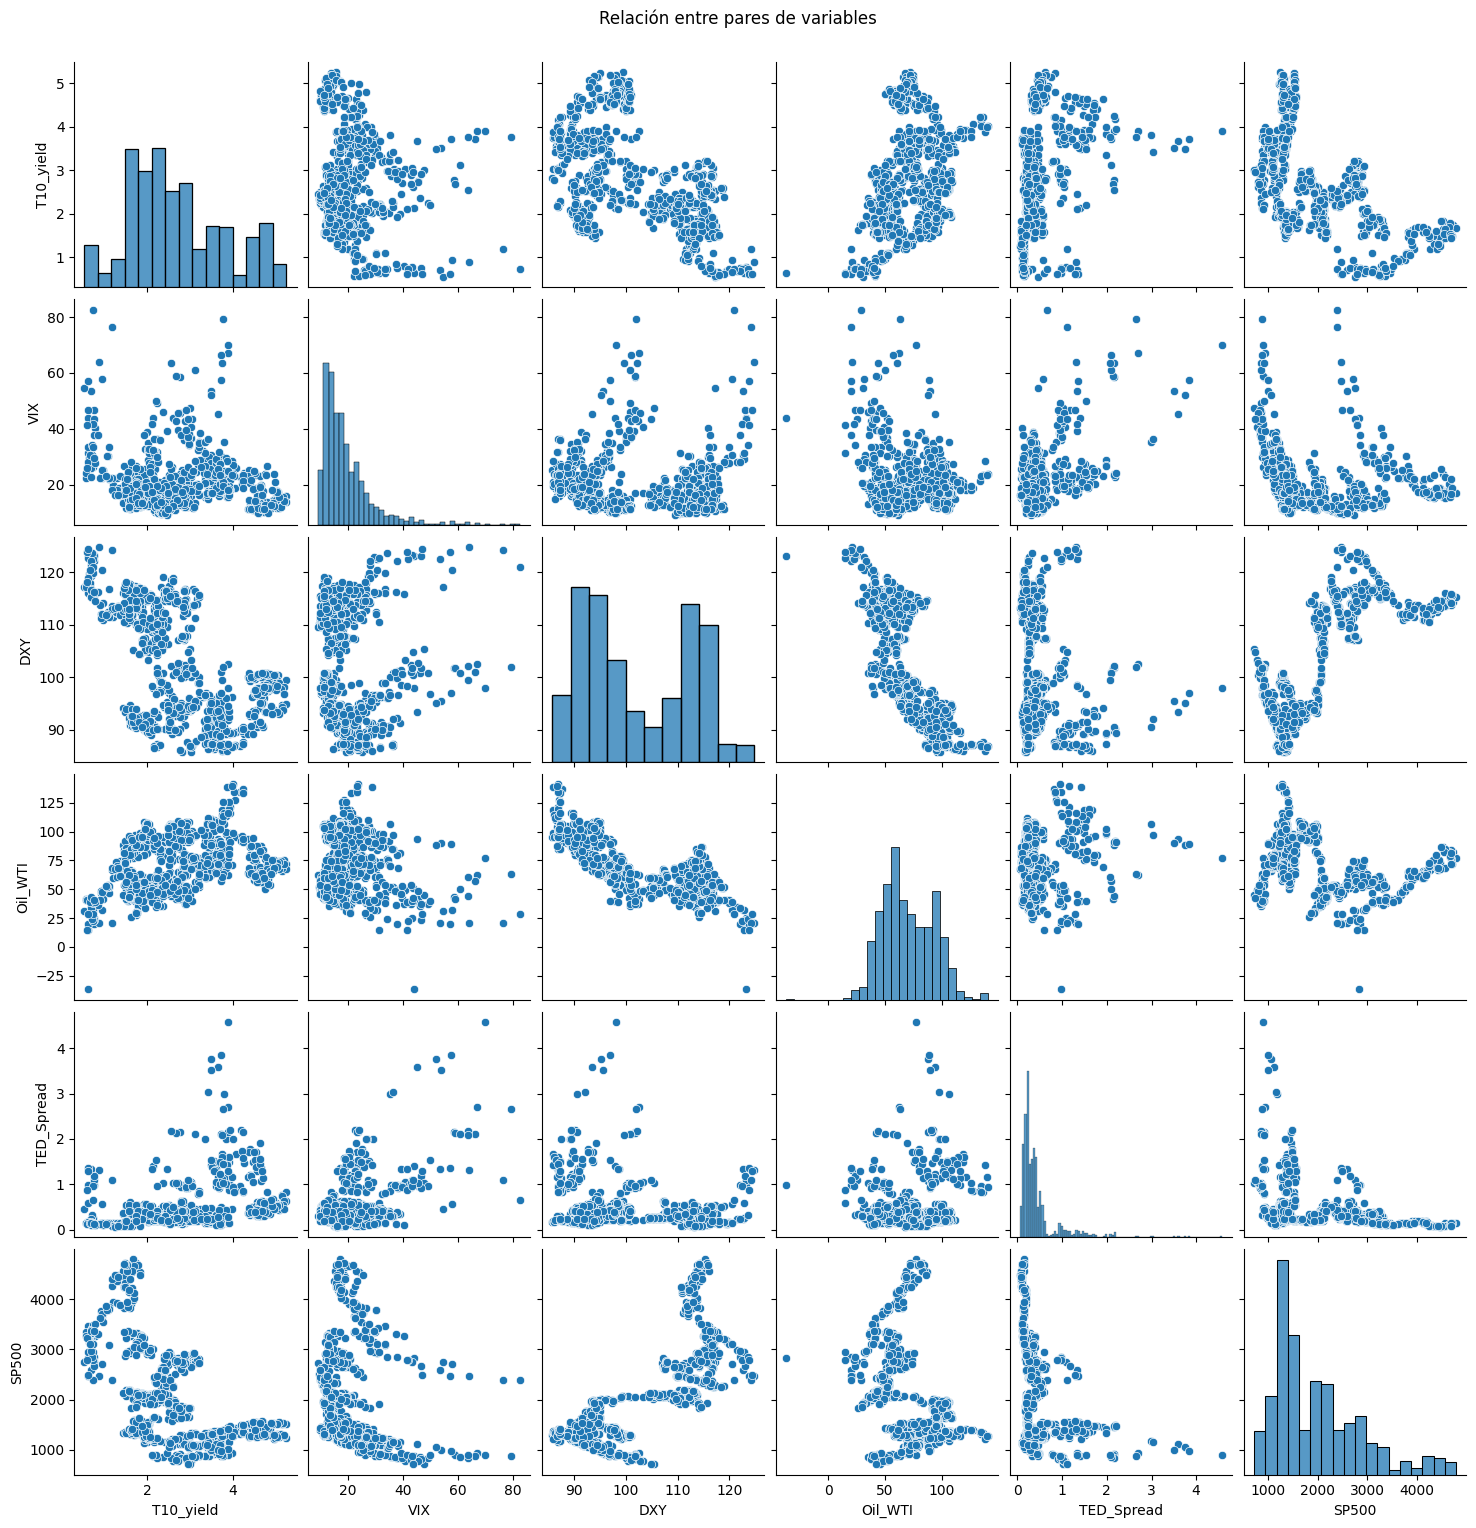

In [8]:
# ---------------------------------------------------------
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ---------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar y preparar la sabana final
df = pd.read_csv("sabana_macro_t10.csv", parse_dates=["Unnamed: 0"])
df = df.rename(columns={"Unnamed: 0": "date"}).set_index("date")

# 1. Resumen estadístico y tipos de datos
print("📊 Resumen estadístico:")
display(df.describe())
print("\n🧾 Tipos de datos:")
print(df.dtypes)

# 2. Distribución de la variable objetivo
plt.figure(figsize=(8, 4))
sns.histplot(df["T10_yield"], kde=True)
plt.title("Distribución del rendimiento del Treasury a 10 años")
plt.xlabel("T10_yield")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

# 4. Histogramas por variable
df.hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("Distribución de variables explicativas", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Boxplot agrupado para detección de outliers y escalas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("Boxplot agrupado de todas las variables")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Series de tiempo por variable
df.plot(subplots=True, layout=(3, 2), figsize=(14, 10), title="Evolución de Variables Macroeconómicas")
plt.tight_layout()
plt.show()

# 7. Pairplot (submuestreo para performance si hay muchos datos)
sample_df = df.sample(n=1000, random_state=42) if len(df) > 1000 else df.copy()
sns.pairplot(sample_df)
plt.suptitle("Relación entre pares de variables", y=1.02)
plt.show()

In [9]:
# ---------------------------------------------------------
# MODELO 1: REGRESIÓN LINEAL 
# ---------------------------------------------------------

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separación de variable dependiente (target) y variables independientes (features)
X = df.drop(columns=["T10_yield"])
y = df["T10_yield"]

# Estandarización de las variables explicativas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal del dataset (80% entrenamiento, 20% test) para evitar data leakage
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Entrenamiento del modelo de regresión lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicción y evaluación del modelo
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print("📈 Modelo 1: Regresión Lineal")
print(f"R² en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")

📈 Modelo 1: Regresión Lineal
R² en test: -2.0570
RMSE en test: 1.1822


In [10]:
# ---------------------------------------------------------
# MODELO 2: ÁRBOL DE DECISIÓN
# ---------------------------------------------------------

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separación entre variables predictoras y variable objetivo
X = df.drop(columns=["T10_yield"])
y = df["T10_yield"]

# Escalado (opcional pero se mantiene por consistencia con otros modelos)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal (80% entrenamiento, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Entrenamiento del Árbol de Decisión
tree = DecisionTreeRegressor(random_state=42, max_depth=5)  # max_depth puede ajustarse luego
tree.fit(X_train, y_train)

# Predicciones y métricas
y_pred = tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print("🌳 Modelo 2: Árbol de Decisión")
print(f"R² en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")

🌳 Modelo 2: Árbol de Decisión
R² en test: -2.6462
RMSE en test: 1.2911


In [11]:
# ---------------------------------------------------------
# MODELO 3: RANDOM FOREST REGRESSOR
# ---------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separación de variables
X = df.drop(columns=["T10_yield"])
y = df["T10_yield"]

# Estandarización (no estrictamente necesaria, pero se mantiene la consistencia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal del dataset
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Entrenamiento del modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print("🌲 Modelo 3: Random Forest")
print(f"R² en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")

🌲 Modelo 3: Random Forest
R² en test: -2.9743
RMSE en test: 1.3480


In [12]:
# ---------------------------------------------------------
# INSTALACIÓN DE XGBOOST (solo si no está previamente instalado)
# ---------------------------------------------------------

try:
    from xgboost import XGBRegressor
except ImportError:
    import sys
    !{sys.executable} -m pip install xgboost

In [13]:
# ---------------------------------------------------------
# MODELO 4: XGBOOST REGRESSOR
# ---------------------------------------------------------

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separación de variables predictoras y objetivo
X = df.drop(columns=["T10_yield"])
y = df["T10_yield"]

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal del dataset
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Entrenamiento del modelo XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb.fit(X_train, y_train)

# Predicción y evaluación
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print("⚡️ Modelo 4: XGBoost Regressor")
print(f"R² en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")

⚡️ Modelo 4: XGBoost Regressor
R² en test: -2.8012
RMSE en test: 1.3183


In [ ]:
# ---------------------------------------------------------
# INSTALACIÓN DE SCIKIT-LEARN (solo si no está instalado)
# ---------------------------------------------------------
try:
    from sklearn.neural_network import MLPRegressor
except ImportError:
    import sys
    !{sys.executable} -m pip install scikit-learn

In [ ]:
# ---------------------------------------------------------
# MODELO 5: RED NEURONAL MULTICAPA (MLPREGRESSOR)
# ---------------------------------------------------------

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Separación de variables
X = df.drop(columns=["T10_yield"])
y = df["T10_yield"]

# Estandarización obligatoria para redes neuronales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División temporal
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Definición y entrenamiento del MLP
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Evaluación
y_pred = mlp.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Resultados
print("🧠 Modelo 5: Red Neuronal Multicapa (MLP)")
print(f"R² en test: {r2:.4f}")
print(f"RMSE en test: {rmse:.4f}")